# Ejemplo LDA vs PCA
## Tratamiento de señales 3-Virtual UdeA
### Paula Andrea Pérez Toro


Utilizaremos 3 bases de datos para observar como actuan cada uno de los algoritmos

- Vinos: tres tipos de vinos.
- Cancer de mama: dos tipos de clases (benigno y maligno).
- Iris: fue utilizada por Fisher en un articulo. Tres clases de flores.

In [186]:
#Sklearn tiene bases de datos para que prueben sus algoritmos
from sklearn.datasets import load_wine,load_breast_cancer,load_iris
import pandas as pd # Dataframes para el manejo de datos y tablas
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


### Bases de datos


In [187]:
data_info = load_wine() #Cargamos la base de datos de vinos
#data_info = load_breast_cancer() #Cargamos la base de datos de cancer de mama
#data_info = load_iris() #Cargamos la base de datos iris

# LDA

Lectura de datos

In [189]:

#Leemos las caracteristicas, se leen de esta forma por que estamos extrayendo información de la base de datos
X = pd.DataFrame(data_info.data, columns=data_info.feature_names) 
#Leemos las etiquetas o labels
y = pd.Categorical.from_codes(data_info.target, data_info.target_names)
#Miraremos como es el tamaño de la base de datos, en donde las columnas seran las caracteristicas 
#y las filas seran las muestras
X.shape

(178, 13)

Miraremos algunas muestras en el dataset, cuando le damos .head() a un dataframe mostramos solo las 5 primeras muestras

In [190]:
X.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Miraremos cuantos clases tendremos


In [191]:
data_info.target_names 

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

Agregaremos las etiquetas o classes en la ultima columna para mejor manejo de los dataframes

In [192]:
df = X.join(pd.Series(y, name='class'))
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


#### 1. Calcularemos ahora las matrices de dispersión intraclases  o $\Sigma_{intra}$

- Primero obtendremos las medias de cada caracteristica en por clase

In [193]:
 # Esta parte es solo para leer las clases
intra_feature_means = pd.DataFrame(columns=data_info.target_names)

#Recorreremos cada clase y hallaremos su media
for c, rows in df.groupby('class'):

    
    intra_feature_means[c] = rows.mean()
intra_feature_means


,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


- Asi obtendremos ya dadas las medias nuestra matriz de dispersion o $\Sigma_{intra}$, como lo vimos en la clase

In [194]:
intraclase_scatter_matrix = np.zeros((X.shape[1],X.shape[1]))


for c, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)

    s = np.zeros((X.shape[1],X.shape[1]))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(X.shape[1],1),intra_feature_means[c].values.reshape(X.shape[1],1)

        s += (x - mc).dot((x - mc).T)

    intraclase_scatter_matrix += s

In [195]:
pd.DataFrame(intraclase_scatter_matrix)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,45.859182,1.430276,-2.329110,-17.013018,3.138271,4.742176,3.960549,-0.170720,2.934978,43.130146,0.136868,-0.872439,2.141495e+03
1,1.430276,155.320689,3.743391,72.582283,-155.634176,-2.534868,-1.646618,1.780654,3.010536,-45.272514,-7.373182,8.142634,-5.785236e+03
2,-2.329110,3.743391,11.562618,84.728099,120.665125,2.829752,5.244934,1.228605,0.469124,1.713984,0.406392,1.909503,-8.767189e+01
3,-17.013018,72.582283,84.728099,1401.191957,566.621139,19.007669,43.123331,8.210113,16.226898,-17.814143,-1.720402,39.485563,-5.745752e+03
4,3.138271,-155.634176,120.665125,566.621139,31615.110304,100.999304,116.697710,-50.235317,227.569448,310.171993,22.077711,-49.197790,8.334355e+04
5,4.742176,-2.534868,2.829752,19.007669,100.999304,33.472333,28.228731,-1.353757,16.072642,34.821922,-0.256415,10.476063,1.469197e+03
6,3.960549,-1.646618,5.244934,43.123331,116.697710,28.228731,48.073815,-2.671745,22.363830,50.168703,-0.736111,11.875839,5.994972e+02
7,-0.170720,1.780654,1.228605,8.210113,-50.235317,-1.353757,-2.671745,2.084548,-1.512148,-0.264371,0.237752,-1.762567,-8.630433e+01
8,2.934978,3.010536,0.469124,16.226898,227.569448,16.072642,22.363830,-1.512148,43.080265,40.111238,-1.103525,7.427303,2.009406e+03
9,43.130146,-45.272514,1.713984,-17.814143,310.171993,34.821922,50.168703,-0.264371,40.111238,399.861539,-7.174341,-11.603398,1.191639e+04


#### 2. Calcularemos ahora las matrices de dispersión interclases  o $\Sigma_{inter}$

- Primero obtendremos las medias por cada caracteristica

In [196]:
inter_feature_means = df.mean()
inter_feature_means

alcohol                          13.000618
malic_acid                        2.336348
ash                               2.366517
alcalinity_of_ash                19.494944
magnesium                        99.741573
total_phenols                     2.295112
flavanoids                        2.029270
nonflavanoid_phenols              0.361854
proanthocyanins                   1.590899
color_intensity                   5.058090
hue                               0.957449
od280/od315_of_diluted_wines      2.611685
proline                         746.893258
dtype: float64

-  Asi obtendremos ya dadas las medias nuestra matriz de dispersion o $\Sigma_{inter}$, como lo vimos en la clase

In [197]:
interclase_scatter_matrix = np.zeros((X.shape[1],X.shape[1]))
for c in intra_feature_means:    
    nC = len(df.loc[df['class'] == c].index) #Numero de muestras en cada clases
    #media_y: media de la caracteristica en cada clase
    #media_x: media de las caracteristicas
    media_y, media_x = intra_feature_means[c].values.reshape(X.shape[1],1),inter_feature_means.values.reshape(X.shape[1],1)
    interclase_scatter_matrix += (nC)* (media_y - media_x).dot((media_y - media_x).T)


In [198]:
interclase_scatter_matrix=pd.DataFrame(interclase_scatter_matrix)
interclase_scatter_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,70.794850,13.722926,10.668493,-131.860426,552.620156,21.256862,30.029331,-2.617784,8.307623,138.875865,-2.493348,8.252953,2.698690e+04
1,13.722926,65.578037,5.155645,117.928430,1.506198,-38.942909,-79.530957,5.429151,-27.993552,159.408872,-17.995455,-59.905838,-6.170913e+03
2,10.668493,5.155645,1.759223,-12.829234,78.094650,1.090017,0.336713,-0.103155,-0.200866,27.429832,-1.235134,-1.774658,3.507266e+03
3,-131.860426,117.928430,-12.829234,572.833493,-1270.153723,-137.801068,-250.581989,18.414556,-82.987089,43.483423,-35.293494,-155.639047,-7.626814e+04
4,552.620156,1.506198,78.094650,-1270.153723,4491.002056,238.215865,377.678695,-30.399402,114.541900,861.660156,9.932963,167.665318,2.297975e+05
5,21.256862,-38.942909,1.090017,-137.801068,238.215865,35.856715,67.434533,-4.849230,22.756440,-48.981483,11.237296,44.574704,1.590708e+04
6,30.029331,-79.530957,0.336713,-250.581989,377.678695,67.434533,128.522390,-9.163714,43.683287,-120.821550,22.698620,86.936580,2.691471e+04
7,-2.617784,5.429151,-0.103155,18.414556,-30.399402,-4.849230,-9.163714,0.656940,-3.100448,7.365701,-1.560150,-6.108490,-2.073730e+03
8,8.307623,-27.993552,-0.200866,-82.987089,114.541900,22.756440,43.683287,-3.100448,14.903991,-46.041431,7.947153,29.907828,8.531711e+03
9,138.875865,159.408872,27.429832,43.483423,861.660156,-48.981483,-120.821550,7.365701,-46.041431,551.416002,-41.767185,-113.325428,2.892945e+04


#### 3. Luego hallaremos los valores y vectores propios

- Calcularemos nuestros vectores y valores propios con la función

    -np.linalg.eig: Calcula los valores y vectores propios de una matriz cuadrada.

In [199]:

valores_propios, vectores_propios = np.linalg.eig(np.linalg.inv(intraclase_scatter_matrix).dot(interclase_scatter_matrix))

- Luego se le aplicara valor absoluto y se organiza en orden descendente

In [200]:
pares_propios = [(np.abs(valores_propios[i]),vectores_propios[:,i]) for i in range(len(valores_propios))] #abs
pares_propios = sorted(pares_propios, key=lambda x: x[0], reverse=True) #Orden descendente
for par in pares_propios:
    print(par[0])

9.081739435042472
4.128469045639484
8.881784197001252e-16
7.41949604398113e-16
7.41949604398113e-16
6.57104310784389e-16
6.57104310784389e-16
2.9039090283069212e-16
2.9039090283069212e-16
2.58525572226227e-16
6.126103277916086e-17
6.126103277916086e-17
4.86945776983596e-17


#### 4. Calcularemos la varianza explicada, el cual es el porcentaje de varianza que aporta cada vector propio, entre mas grande más información nos aporta.

In [202]:
suma_valor_propio = sum(valores_propios)
print('Varianza Explicada')
for i, par in enumerate(pares_propios):
    
    print('Vector Propio {}: {}'.format(i, (par[0]/suma_valor_propio).real*100 )+ '%')

Varianza Explicada
Vector Propio 0: 68.74788878860784%
Vector Propio 1: 31.252111211392165%
Vector Propio 2: 6.723424698398662e-15%
Vector Propio 3: 5.616486715430028e-15%
Vector Propio 4: 5.616486715430028e-15%
Vector Propio 5: 4.974216052269805e-15%
Vector Propio 6: 4.974216052269805e-15%
Vector Propio 7: 2.1982310366664336e-15%
Vector Propio 8: 2.1982310366664336e-15%
Vector Propio 9: 1.9570135672293418e-15%
Vector Propio 10: 4.637400906181486e-16%
Vector Propio 11: 4.637400906181486e-16%
Vector Propio 12: 3.686132415666904e-16%


#### 5. Ahora ya podremos obtener nuestro $\boldsymbol{W}$
$$\phi(\boldsymbol{X})=\boldsymbol{W}^{T}\boldsymbol{X}$$

In [203]:
w_matrix = np.hstack((pares_propios[0][1].reshape(X.shape[1],1), pares_propios[1][1].reshape(X.shape[1],1))).real

In [204]:
pd.DataFrame(w_matrix)

,0,1
0,-0.143683,-0.254447
1,0.058860,-0.089130
2,-0.131457,-0.684674
3,0.055136,0.042724
4,-0.000771,0.000135
5,0.220138,0.009402
6,-0.591684,0.143598
7,-0.532781,0.476020
8,0.047761,0.089628
9,0.126464,-0.073909


#### 6. $$\phi(\boldsymbol{X})=\boldsymbol{W}^{T}\boldsymbol{X}$$

p: dimension del espacio de caracteristicas transformado por LDA=k-1=3-1=2

m:numero de muestras=150

d: dimension original de las caracteristicas=4

X: matriz mxd (150x4)
W: matriz dxp (4x2)

$\phi(X): matriz (150x4) \dot (4x2)= matriz 150x2$

mxd dxp





In [205]:
X_lda = np.array(X.dot(w_matrix))
pd.DataFrame(X_lda)

,0,1
0,-4.961962,-4.851209
1,-4.820100,-4.615169
2,-4.506220,-4.690671
3,-4.785834,-5.441868
4,-3.825653,-4.405262
5,-4.897296,-5.211371
6,-4.900391,-5.227711
7,-4.765387,-5.179552
8,-4.662979,-4.843691
9,-4.486953,-4.763504


Label encoder se utiliza cuando tienes etiquetas categoricas y las quieres pasar a variables de números discretos

In [206]:
data_info.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [207]:
le = LabelEncoder()
y = le.fit_transform(df['class'])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

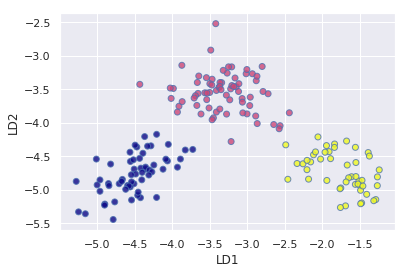

In [208]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='plasma',
    alpha=0.8,
    edgecolors='b'
)
plt.show()

## Ahora resumiremos esto usando la función de sklearn para analisis discriminante

In [209]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

X_lda = lda.fit_transform(X, y) #Entrenaremos y transformaremos los datos

#### Para reducción de dimensión

Varianza explicada

In [210]:
lda.explained_variance_ratio_

array([0.6875, 0.3125])

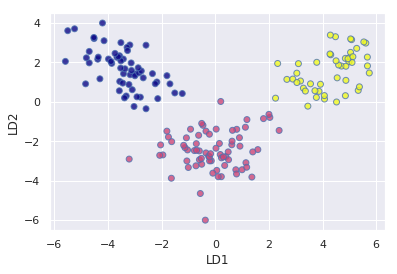

In [211]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='plasma',
    alpha=0.8,
    edgecolors='b'
)

#### Para clasificación

train_test_split de sckitlearn: divide los datos en train y test

También se puede hacer manual

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
lda_clasification = LinearDiscriminantAnalysis()


##### Entrenamos con nuestros datos de train o de entrenamiento

In [249]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [250]:
lda_clasification.fit(X_train, y_train) 

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

##### Realizamos las predicciones con nuestros datos de test

In [251]:
y_pred=lda_clasification.predict(X_test) 
y_pred, y_test

(array([2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2,
        1]),
 array([0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 1, 1,
        2]))

Comprobamos cuales etiquetas nos dieron igual

In [253]:
y_test==y_pred

array([False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False,  True,  True,  True, False, False])

#### El problema fue muy facil de identificar, ahora veamos que resulta con PCA

# PCA

In [254]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #<=d no >
X_pca = pca.fit_transform(X)
X_pca.shape

(178, 2)

In [255]:
pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)

(array([0.9981, 0.0017]), 0.9998271461166032)

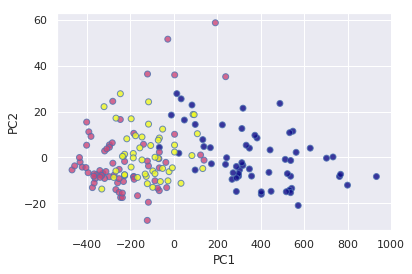

In [256]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='plasma',
    alpha=0.8,
    edgecolors='b'
)

#### Podemos utilizar las caracteristicas resultantes en PCA para clasificar con LDA (pura curiosidad)

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y,test_size=0.25, random_state=42, shuffle=True)
lda_clasification = LinearDiscriminantAnalysis()

In [261]:
lda_clasification.fit(X_train, y_train) 

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [262]:
y_pred=lda_clasification.predict(X_test) 


In [263]:
y_test==y_pred

array([False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False,  True,  True,  True, False, False])